In [ ]:
# DPItorch/notebooks/DPI PET results.ipynb
# 导入必要的库
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy.io
import h5py
from pathlib import Path
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

# 自定义绘图设置 (可选)
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用于正常显示负号

# --- 用户配置区域 ---
# 请根据您的实际情况修改以下路径和参数
MODEL_PATH = "../checkpoint/pet64-flow16-1000/realnvp_flow16_ld1e+00_tv1e+00_l10e+00_lr5e-05_batch64_size64_adaptScale_final.pth"  # 修改为您的模型 .pth 文件路径
LOSS_CURVE_PATH = "../checkpoint/pet64-flow16-1000/loss_realnvp_flow16_ld1e+00_tv1e+00_l10e+00_lr5e-05_batch64_size64_adaptScale.npy" # 修改为您的损失 .npy 文件路径

# 数据路径 (与训练时使用的数据对应)
# 您需要根据训练时使用的 image_size 来设置这些路径
IMAGE_SIZE = 64 # 或 128，根据您的模型
FRAME_IDX = 10  # 与训练时相同
ROI_IDX = 30    # 与训练时相同

if IMAGE_SIZE == 64:
    ACTIVITY_PATH = "../../dataset/brain64_tumor_activity_map/brain64_tumor_FDG_K1_40min.mat"
    SINOGRAM_PATH = "../../dataset/brain64_tumor_sinogram/brain64_tumor_FDG_K1_40min.mat"
    GMAT_PATH = "../../dataset/G_system_matrix_64.mat"
    RI_PATH = "../../dataset/brain64_tumor_sinogram/brain64_tumor_FDG_K1_40min_ri.mat"
    CI_PATH = "../../dataset/brain64_tumor_sinogram/brain64_tumor_FDG_K1_40min_ci.mat"
    YTRUE_PATH = "../../dataset/brain64_tumor_sinogram/brain64_tumor_FDG_K1_40min_ytrue.mat" # 用于对比真实投影
elif IMAGE_SIZE == 128:
    ACTIVITY_PATH = "../../dataset/brain128_tumor_activity_map/brain128_tumor_FDG_K1_40min.mat"
    SINOGRAM_PATH = "../../dataset/brain128_tumor_sinogram/brain128_tumor_FDG_K1_40min.mat"
    GMAT_PATH = "../../dataset/G_system_matrix.mat"
    RI_PATH = "../../dataset/brain128_tumor_sinogram/brain128_tumor_FDG_K1_40min_ri.mat"
    CI_PATH = "../../dataset/brain128_tumor_sinogram/brain128_tumor_FDG_K1_40min_ci.mat"
    YTRUE_PATH = "../../dataset/brain128_tumor_sinogram/brain128_tumor_FDG_K1_40min_ytrue.mat"
else:
    raise ValueError(f"Unsupported IMAGE_SIZE: {IMAGE_SIZE}")

# 生成模型参数 (应与训练时模型结构一致)
N_FLOW = 32 # 例如，或者您在训练时使用的值
MODEL_FORM = "realnvp" # 或 "glow"
# N_BLOCK = 4 # for Glow

# 设备设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [49]:

# --- 辅助函数 ---
def load_mat(fp: str, key: str):
    try:
        return scipy.io.loadmat(fp)[key]
    except NotImplementedError:
        with h5py.File(fp, 'r') as f:
            return np.array(f[key]).T

def plot_img(img_array, title="", cmap='hot', clim=None):
    plt.imshow(img_array, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    if clim:
        plt.clim(clim)
    plt.colorbar()
    plt.tight_layout()


# Load the learned DPI normalizing flow for PET

In [50]:

# --- 1. 加载数据 ---
print("加载原始数据...")
act4d = load_mat(ACTIVITY_PATH, 'tracer')
sino4d = load_mat(SINOGRAM_PATH, 'sinogram')
act_gt_full_res = act4d[:, :, ROI_IDX, FRAME_IDX]

# 确保 act_gt 与目标 image_size 一致
if act_gt_full_res.shape[0] != IMAGE_SIZE or act_gt_full_res.shape[1] != IMAGE_SIZE:
    import cv2
    act_gt = cv2.resize(act_gt_full_res, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
else:
    act_gt = act_gt_full_res

y_vec_true_observed = torch.tensor(
    sino4d[:, :, ROI_IDX, FRAME_IDX].T.flatten(),
    dtype=torch.float32, device=device)

# 加载系统矩阵 A, ci, ri
Gsp = scipy.sparse.csc_matrix(load_mat(GMAT_PATH, 'G_sparse'))
coo = Gsp.tocoo()
A_torch = torch.sparse_coo_tensor(
    np.vstack((coo.row, coo.col)), coo.data, Gsp.shape,
    dtype=torch.float32, device=device).coalesce()

ci_slice = load_mat(CI_PATH, 'ci')[:, :, ROI_IDX, FRAME_IDX]
ci_vec = torch.tensor(ci_slice.T.flatten(), dtype=torch.float32, device=device)

ri_slice = load_mat(RI_PATH, 'ri')[:, :, ROI_IDX, FRAME_IDX]
ri_vec = torch.tensor(ri_slice.T.flatten(), dtype=torch.float32, device=device)

ytrue_slice = load_mat(YTRUE_PATH, 'ytrue')[:, :, ROI_IDX, FRAME_IDX]
ytrue_vec = torch.tensor(ytrue_slice.T.flatten(), dtype=torch.float32, device=device)


print(f"Ground truth activity shape: {act_gt.shape}")
print(f"Observed sinogram vector shape: {y_vec_true_observed.shape}")
print(f"System matrix shape: {A_torch.shape}")


加载原始数据...
Ground truth activity shape: (64, 64)
Observed sinogram vector shape: torch.Size([10240])
System matrix shape: torch.Size([10240, 4096])


In [60]:

# --- 2. 加载训练好的模型 ---
print(f"加载模型: {MODEL_PATH}")
# 重新导入模型定义 (确保与训练脚本中的定义一致)
# 您可能需要将 generative_model.py 或其部分内容复制到此 notebook 或确保它在 Python 路径中
# 例如: from generative_model import realnvpfc_model, glow_model (假设这些在您的环境中可用)
# 这里我们用 DPI_PET.py 中的定义作为参考
# (确保 RealNVP 和 ImgLogScale 类定义在此处可用或已导入)
# ---- 开始：从DPI_PET.py复制的模型和辅助类定义 ----
class ImgLogScale(torch.nn.Module):
    def __init__(self, init_scale=1.0):
        super().__init__()
        self.log_scale = torch.nn.Parameter(torch.tensor([np.log(init_scale)], dtype=torch.float32))
    def forward(self):
        return self.log_scale

# 假设 realnvpfc_model 和 glow_model 可以在环境中找到
# 例如，如果它们在 DPItorch 目录下，可以这样添加路径：
import sys
sys.path.append(str(Path.cwd().parent)) # 添加 DPItorch 目录到 sys.path
from generative_model import realnvpfc_model, glow_model

N_PIX = IMAGE_SIZE * IMAGE_SIZE
if MODEL_FORM == 'realnvp':
    Gnet = realnvpfc_model.RealNVP(N_PIX, N_FLOW, affine=True).to(device)
    print("RealNVP 模型已构建")
elif MODEL_FORM == 'glow':
    z_shapes = glow_model.calc_z_shapes(1, IMAGE_SIZE, N_FLOW, N_BLOCK) # 假设 n_channel=1
    Gnet = glow_model.Glow(1, IMAGE_SIZE, N_FLOW, N_BLOCK, affine=True).to(device) # 假设 n_channel=1
    print("Glow 模型已构建")
else:
    raise ValueError(f"不支持的模型类型: {MODEL_FORM}")

checkpoint = torch.load(MODEL_PATH, map_location=device)
Gnet.load_state_dict(checkpoint['model_state_dict'])
Gnet.eval() # 设置为评估模式
print("模型权重已加载.")

use_learnable_scale = 'logscale_state_dict' in checkpoint
if use_learnable_scale:
    logscale_module = ImgLogScale(init_scale=1.0).to(device) # init_scale不重要，因为会加载
    logscale_module.load_state_dict(checkpoint['logscale_state_dict'])
    logscale_module.eval()
    learned_scale_factor = torch.exp(logscale_module()).item()
    print(f"可学习缩放因子已加载，值为: {learned_scale_factor:.4f}")
else:
    # 检查是否保存了固定缩放的信息（DPI_PET.py的较新版本会保存）
    if 'fixed_scale' in checkpoint:
        fixed_scale_factor = checkpoint['fixed_scale']
        print(f"模型训练时使用了固定缩放或无显式缩放，参考固定缩放值: {fixed_scale_factor:.4f}")
    else: # 旧模型可能没有这个字段
        fixed_scale_factor = np.mean(act_gt) # Fallback or a placeholder
        print(f"未找到固定缩放因子信息，使用act_gt均值作为参考: {fixed_scale_factor:.4f}")
    learned_scale_factor = None # 表示不使用可学习的

加载模型: ../checkpoint/pet64-flow16-1000/realnvp_flow16_ld1e+00_tv1e+00_l10e+00_lr5e-05_batch64_size64_adaptScale_final.pth
RealNVP 模型已构建
模型权重已加载.
可学习缩放因子已加载，值为: 4.0838


# Generate and plot image samples

In [65]:

# --- 3. 从模型生成重建样本 ---
N_SAMPLES = 64 # 您希望生成的样本数量，用于计算均值和标准差
print(f"生成 {N_SAMPLES} 个重建样本...")

all_samples_np = []
with torch.no_grad():
    for _ in range(N_SAMPLES // (N_SAMPLES if N_SAMPLES < 64 else 64) ): # 批处理生成，避免显存问题
        current_batch_size = N_SAMPLES if N_SAMPLES < 64 else 64
        if MODEL_FORM == 'realnvp':
            z_sample = torch.randn(current_batch_size, N_PIX, device=device)
        else: # Glow
            z_sample = [torch.randn(current_batch_size, *s, device=device) for s in z_shapes]

        img_raw, _ = Gnet.reverse(z_sample)
        img_raw = img_raw.view(-1, IMAGE_SIZE, IMAGE_SIZE)

        if use_learnable_scale and logscale_module is not None:
            img_pos = torch.nn.functional.softplus(img_raw) * torch.exp(logscale_module())
        else:
            # 如果训练时没有用可学习的，这里也只用softplus
            # 如果您在训练时用了固定的缩放，可以在这里乘上它
            img_pos = torch.nn.functional.softplus(img_raw)
            # if not use_learnable_scale and fixed_scale_factor is not None:
            #    img_pos = img_pos * fixed_scale_factor


        all_samples_np.append(img_pos.cpu().numpy())

all_samples_np = np.concatenate(all_samples_np, axis=0)
print(f"生成样本形状: {all_samples_np.shape}") # (N_SAMPLES, IMAGE_SIZE, IMAGE_SIZE)

# 计算均值和标准差图像
mean_recon_img = np.mean(all_samples_np, axis=0)
std_recon_img = np.std(all_samples_np, axis=0)


生成 64 个重建样本...
生成样本形状: (64, 64, 64)


显示重建结果...


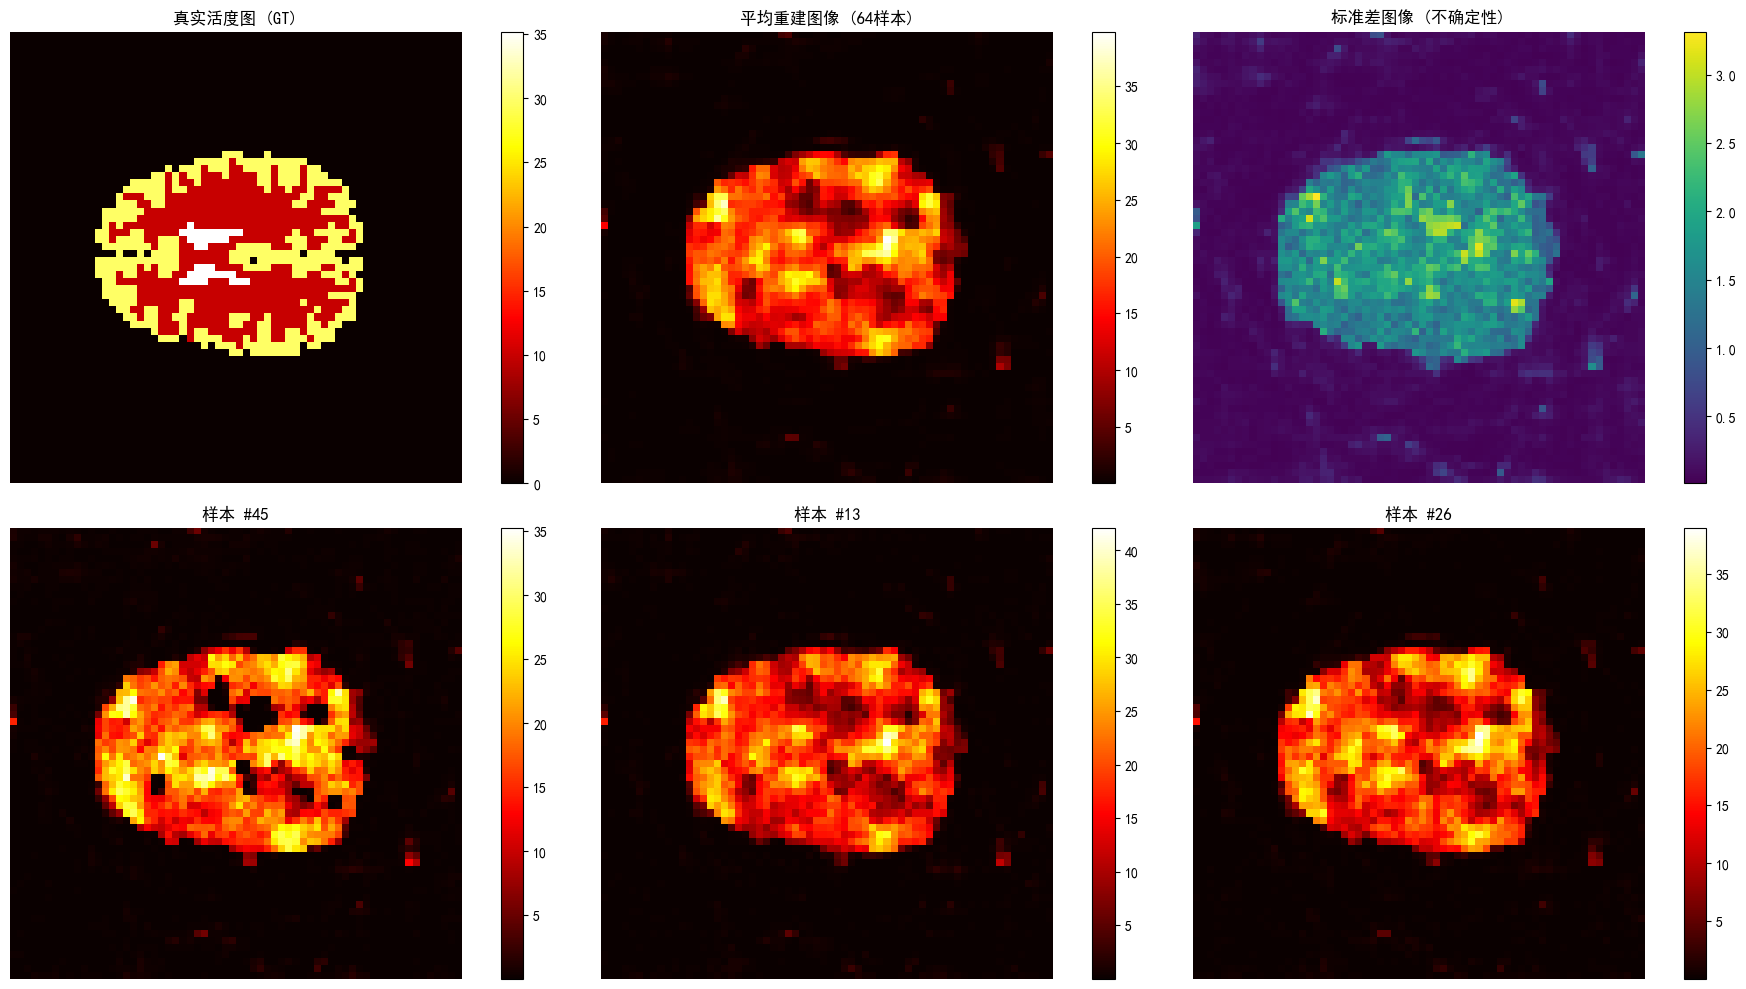

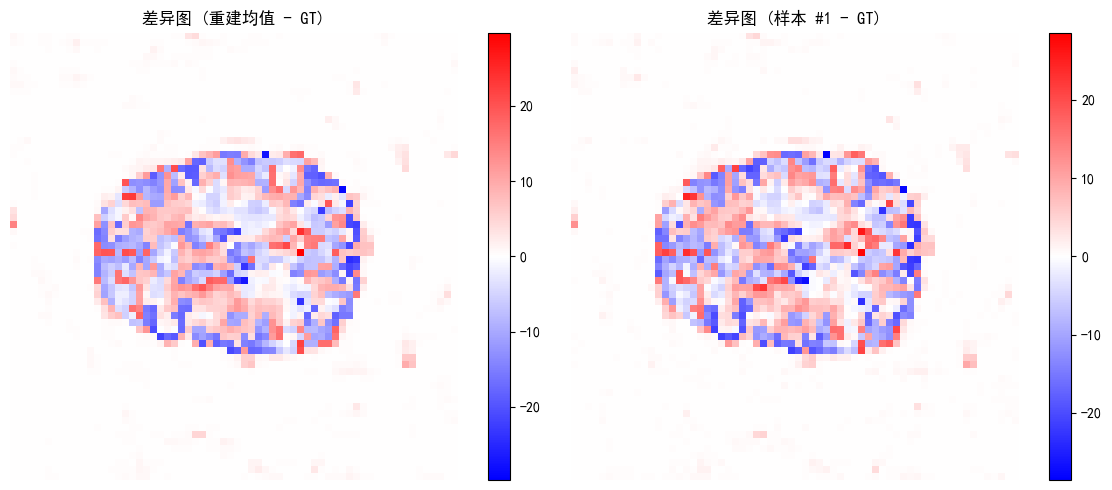

In [66]:

# --- 4. 定性评估 - 图像显示 ---
print("显示重建结果...")
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plot_img(act_gt, title=f"真实活度图 (GT)", cmap='hot')

plt.subplot(2, 3, 2)
plot_img(mean_recon_img, title=f"平均重建图像 ({N_SAMPLES}样本)", cmap='hot')

plt.subplot(2, 3, 3)
plot_img(std_recon_img, title=f"标准差图像 (不确定性)", cmap='viridis') # viridis更适合标准差

plt.subplot(2, 3, 4)
# 选取几个样本展示
sample_to_show_idx = np.random.choice(N_SAMPLES, 3, replace=False)
for i, sample_idx in enumerate(sample_to_show_idx):
    plt.subplot(2, 3, 4+i)
    plot_img(all_samples_np[sample_idx], title=f"样本 #{sample_idx+1}", cmap='hot')
    if i >= 2 : break # 最多显示3个

plt.tight_layout()
plt.show()

# 显示差异图像
plt.figure(figsize=(12, 5))
diff_img = mean_recon_img - act_gt
max_abs_diff = np.max(np.abs(diff_img))

plt.subplot(1, 2, 1)
plot_img(diff_img, title="差异图 (重建均值 - GT)", cmap='bwr', clim=(-max_abs_diff, max_abs_diff))

plt.subplot(1, 2, 2)
# 也可以显示某个特定样本与GT的差异
sample_idx_for_diff = 0
diff_sample_img = all_samples_np[sample_idx_for_diff] - act_gt
max_abs_diff_sample = np.max(np.abs(diff_sample_img))
plot_img(diff_sample_img, title=f"差异图 (样本 #{sample_idx_for_diff+1} - GT)", cmap='bwr', clim=(-max_abs_diff_sample, max_abs_diff_sample))

plt.tight_layout()
plt.show()

In [68]:

# --- 5. 定量评估 - 指标计算 ---
print("计算定量评估指标...")
mse_val = mean_squared_error(act_gt, mean_recon_img)
psnr_val = peak_signal_noise_ratio(act_gt, mean_recon_img, data_range=act_gt.max())
ssim_val = structural_similarity(act_gt, mean_recon_img, data_range=act_gt.max())

print(f"对于平均重建图像 vs GT:")
print(f"  MSE : {mse_val:.6f}")
print(f"  PSNR: {psnr_val:.2f} dB")
print(f"  SSIM: {ssim_val:.4f}")

# 您也可以计算每个样本的指标，然后报告平均值和标准差
mses_samples = [mean_squared_error(act_gt, all_samples_np[i]) for i in range(N_SAMPLES)]
psnrs_samples = [peak_signal_noise_ratio(act_gt, all_samples_np[i], data_range=act_gt.max()) for i in range(N_SAMPLES)]
ssims_samples = [structural_similarity(act_gt, all_samples_np[i], data_range=act_gt.max()) for i in range(N_SAMPLES)]

print(f"\n对于 {N_SAMPLES} 个独立样本 (均值 ± 标准差):")
print(f"  MSE : {np.mean(mses_samples):.6f} ± {np.std(mses_samples):.6f}")
print(f"  PSNR: {np.mean(psnrs_samples):.2f} ± {np.std(psnrs_samples):.2f} dB")
print(f"  SSIM: {np.mean(ssims_samples):.4f} ± {np.std(ssims_samples):.4f}")


计算定量评估指标...
对于平均重建图像 vs GT:
  MSE : 23.846923
  PSNR: 17.16 dB
  SSIM: 0.6432

对于 64 个独立样本 (均值 ± 标准差):
  MSE : 24.571704 ± 0.477073
  PSNR: 17.03 ± 0.08 dB
  SSIM: 0.6377 ± 0.0071


进行投影域分析...


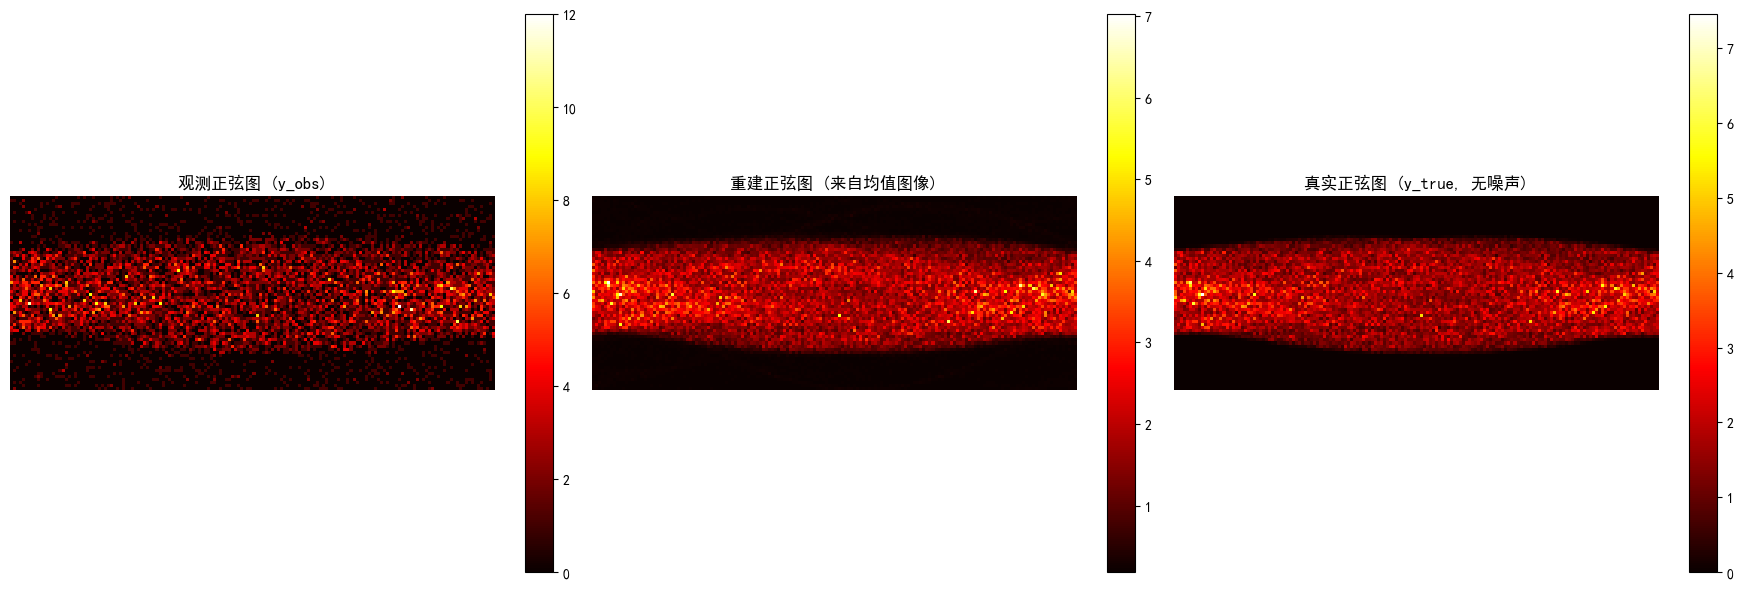

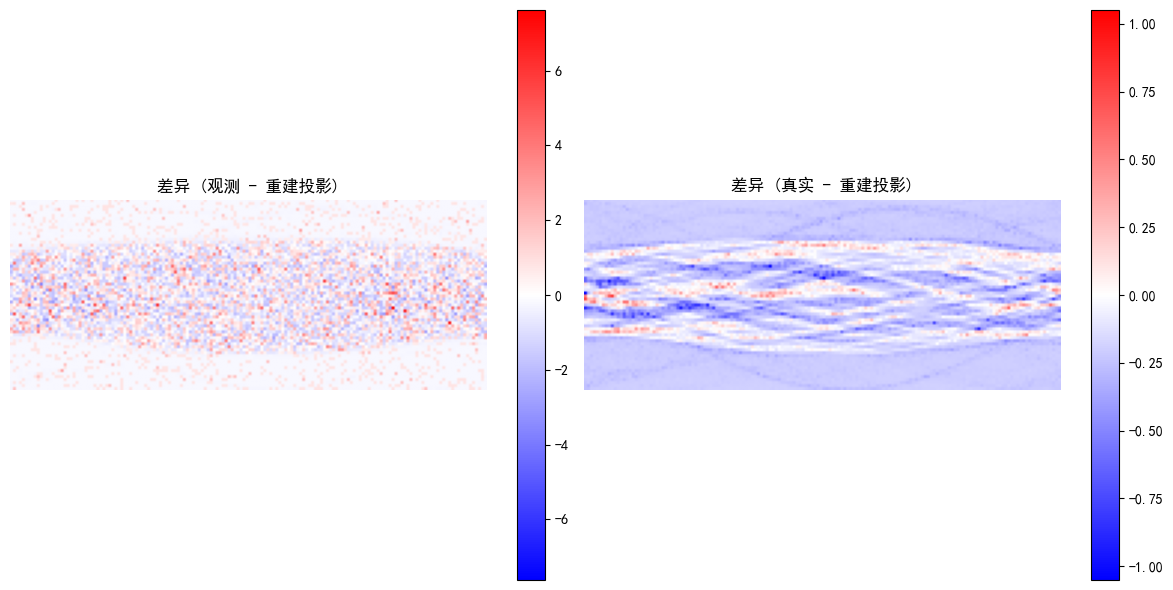

In [69]:

# --- 6. 投影域分析 (可选) ---
print("进行投影域分析...")
# 将平均重建图像投影回正弦图空间
mean_recon_img_vec = torch.tensor(mean_recon_img.flatten(order='F'), dtype=torch.float32, device=device) # Fortran order
proj_mean_recon_no_ci_ri = torch.sparse.mm(A_torch, mean_recon_img_vec.unsqueeze(1)).squeeze()
lam_recon = ci_vec * proj_mean_recon_no_ci_ri + ri_vec
lam_recon_np = lam_recon.cpu().numpy()

# 重塑为2D正弦图 (nb, na) -> (na, nb).T
nb_sino, na_sino = sino4d.shape[0], sino4d.shape[1] # 从原始sino4d获取维度

try:
    y_obs_reshaped = y_vec_true_observed.cpu().numpy().reshape(na_sino, nb_sino).T
    lam_recon_reshaped = lam_recon_np.reshape(na_sino, nb_sino).T
    ytrue_reshaped = ytrue_vec.cpu().numpy().reshape(na_sino, nb_sino).T


    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plot_img(y_obs_reshaped, title="观测正弦图 (y_obs)", cmap='hot')

    plt.subplot(1, 3, 2)
    plot_img(lam_recon_reshaped, title="重建正弦图 (来自均值图像)", cmap='hot')
    
    plt.subplot(1, 3, 3)
    plot_img(ytrue_reshaped, title="真实正弦图 (y_true, 无噪声)", cmap='hot')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    diff_sino_obs_recon = y_obs_reshaped - lam_recon_reshaped
    max_abs_diff_sino = np.max(np.abs(diff_sino_obs_recon))
    plt.subplot(1, 2, 1)
    plot_img(diff_sino_obs_recon, "差异 (观测 - 重建投影)", cmap='bwr', clim=(-max_abs_diff_sino, max_abs_diff_sino))

    diff_sino_true_recon = ytrue_reshaped - lam_recon_reshaped
    max_abs_diff_sino_true = np.max(np.abs(diff_sino_true_recon))
    plt.subplot(1, 2, 2)
    plot_img(diff_sino_true_recon, "差异 (真实 - 重建投影)", cmap='bwr', clim=(-max_abs_diff_sino_true, max_abs_diff_sino_true))
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"重塑或绘制正弦图失败: {e}. 可能是维度不匹配。")
    print(f"  y_obs shape: {y_vec_true_observed.shape}, lam_recon_np shape: {lam_recon_np.shape}, ytrue_vec shape: {ytrue_vec.shape}")
    print(f"  Expected reshape dimensions: na_sino={na_sino}, nb_sino={nb_sino}")


加载并绘制损失曲线: ../checkpoint/pet64-flow16-1000/loss_realnvp_flow16_ld1e+00_tv1e+00_l10e+00_lr5e-05_batch64_size64_adaptScale.npy


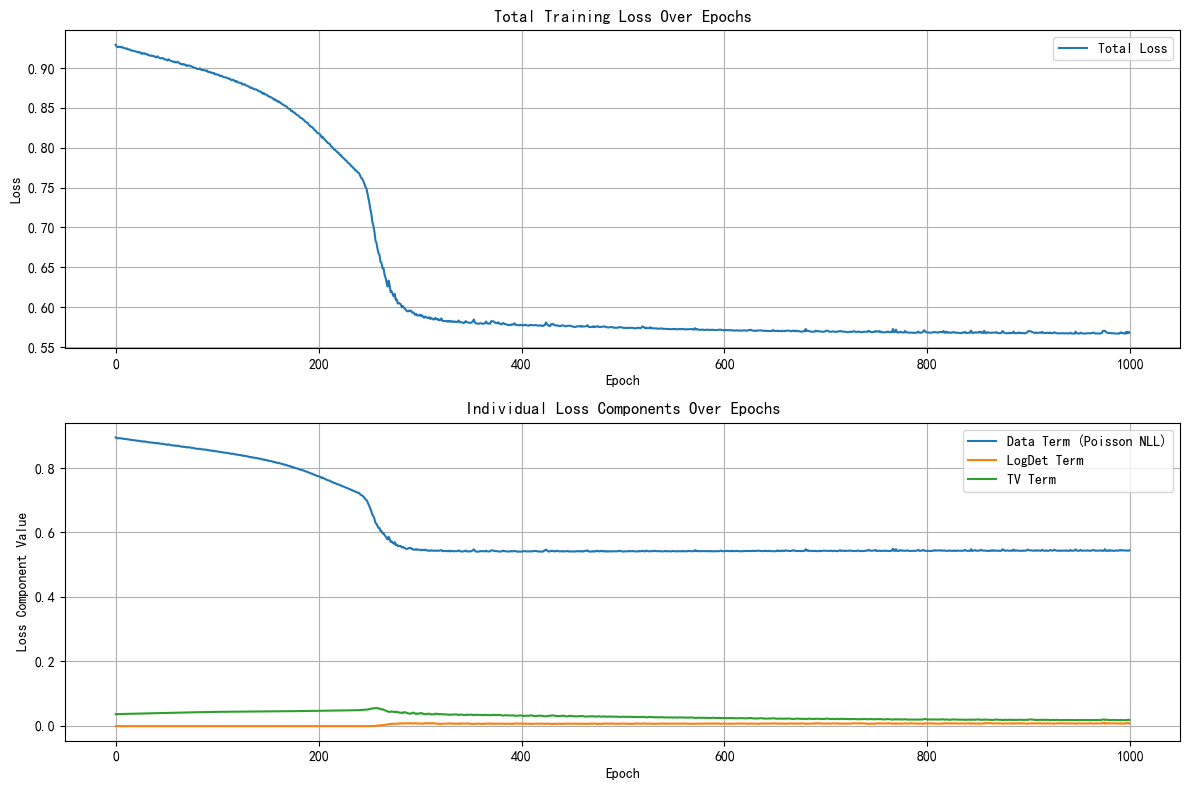

--- 分析完成 ---


In [70]:

# --- 7. 损失曲线分析 ---
print(f"加载并绘制损失曲线: {LOSS_CURVE_PATH}")
try:
    loss_rec = np.load(LOSS_CURVE_PATH, allow_pickle=True).item()

    epochs = np.arange(len(loss_rec['total']))

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss_rec['total'], label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Total Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    if 'data' in loss_rec: plt.plot(epochs, loss_rec['data'], label='Data Term (Poisson NLL)')
    if 'logdet' in loss_rec: plt.plot(epochs, loss_rec['logdet'], label='LogDet Term')
    if 'tv' in loss_rec and np.any(loss_rec['tv']): plt.plot(epochs, loss_rec['tv'], label='TV Term') # Plot if not all zeros
    if 'l1' in loss_rec and np.any(loss_rec['l1']): plt.plot(epochs, loss_rec['l1'], label='L1 Term') # Plot if not all zeros
    plt.xlabel('Epoch')
    plt.ylabel('Loss Component Value')
    plt.title('Individual Loss Components Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"错误: 损失曲线文件 {LOSS_CURVE_PATH} 未找到.")
except Exception as e:
    print(f"加载或绘制损失曲线时出错: {e}")

print("--- 分析完成 ---")


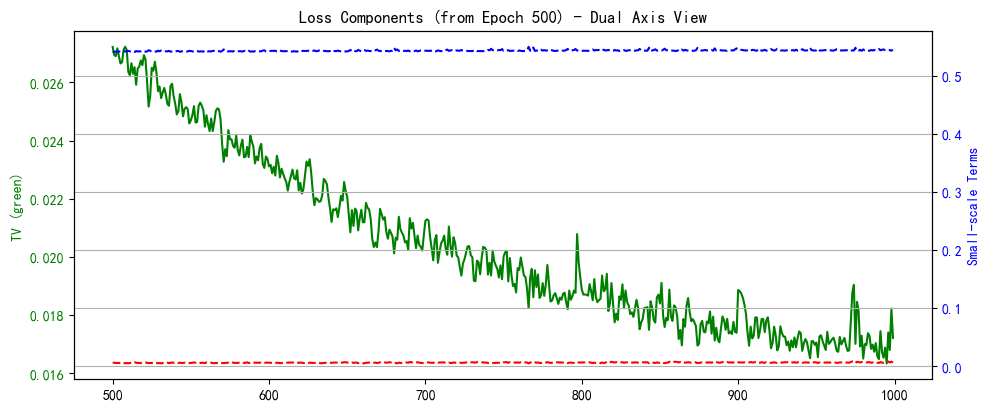

In [71]:
start_epoch = 500
epochs = np.arange(len(loss_rec['total']))
mask = epochs >= start_epoch
epochs = epochs[mask]

# 转换为 numpy 数组以支持布尔索引
tv = np.array(loss_rec['tv'])
data = np.array(loss_rec['data'])
logdet = np.array(loss_rec['logdet'])

fig, ax1 = plt.subplots(figsize=(10, 4))

# 主轴：TV
ax1.plot(epochs, tv[mask], 'g-', label='TV Term')
ax1.set_ylabel('TV (green)', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# 副轴：Data 和 LogDet
ax2 = ax1.twinx()
ax2.plot(epochs, data[mask], 'b--', label='Data Term')
ax2.plot(epochs, logdet[mask], 'r--', label='LogDet')
ax2.set_ylabel('Small-scale Terms', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# 图标题和布局
fig.tight_layout()
plt.title(f'Loss Components (from Epoch {start_epoch}) - Dual Axis View')
plt.grid(True)
plt.show()
